In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

print("Imports loaded")

Imports loaded


In [2]:
# load sample data
df_raw = pd.read_csv("../data/processed/US_Accidents_March23.csv")
print(f"Loaded {len(df_raw)} rows")
print(f"Columns: {len(df_raw.columns)}")

Loaded 20000 rows
Columns: 46


In [3]:
# extract temporal features from Start_Time
df_raw['Start_Time'] = pd.to_datetime(df_raw['Start_Time'])
df_temporal = df_raw.copy()
df_temporal['hour'] = df_temporal['Start_Time'].dt.hour
df_temporal['day_of_week'] = df_temporal['Start_Time'].dt.dayofweek + 1

# add rush hour flag (7-9am and 4-7pm are rush hours)
df_temporal['rush_hour'] = 0
df_temporal.loc[(df_temporal['hour'] >= 7) & (df_temporal['hour'] <= 9), 'rush_hour'] = 1
df_temporal.loc[(df_temporal['hour'] >= 16) & (df_temporal['hour'] <= 19), 'rush_hour'] = 1

# add weekend flag (day 1=Sunday, 7=Saturday)
df_temporal['is_weekend'] = 0
df_temporal.loc[(df_temporal['day_of_week'] == 1) | (df_temporal['day_of_week'] == 7), 'is_weekend'] = 1

print("Added temporal features: hour, day_of_week, rush_hour, is_weekend")
print(df_temporal[['Start_Time', 'hour', 'day_of_week', 'rush_hour', 'is_weekend']].head())

Added temporal features: hour, day_of_week, rush_hour, is_weekend
           Start_Time  hour  day_of_week  rush_hour  is_weekend
0 2016-10-05 12:02:57    12            3          0           0
1 2016-10-13 14:26:35    14            4          0           0
2 2017-01-04 20:33:30    20            3          0           0
3 2016-11-14 18:21:29    18            1          1           1
4 2016-09-27 22:10:35    22            2          0           0


In [4]:
# create weather condition flags
df_weather = df_temporal.copy()

df_weather['is_clear'] = 0
df_weather.loc[df_weather['Weather_Condition'].str.lower().str.contains('clear|fair', na=False), 'is_clear'] = 1

df_weather['is_rainy'] = 0
df_weather.loc[df_weather['Weather_Condition'].str.lower().str.contains('rain|drizzle|shower', na=False), 'is_rainy'] = 1

df_weather['is_foggy'] = 0
df_weather.loc[df_weather['Weather_Condition'].str.lower().str.contains('fog|mist|haze', na=False), 'is_foggy'] = 1

df_weather['is_snowy'] = 0
df_weather.loc[df_weather['Weather_Condition'].str.lower().str.contains('snow|ice|sleet', na=False), 'is_snowy'] = 1

print("Added weather flags: is_clear, is_rainy, is_foggy, is_snowy")
print(df_weather[['Weather_Condition', 'is_clear', 'is_rainy', 'is_foggy', 'is_snowy']].head())

Added weather flags: is_clear, is_rainy, is_foggy, is_snowy
  Weather_Condition  is_clear  is_rainy  is_foggy  is_snowy
0             Clear         1         0         0         0
1             Clear         1         0         0         0
2     Mostly Cloudy         0         0         0         0
3          Overcast         0         0         0         0
4     Partly Cloudy         0         0         0         0


In [5]:
# create road type flags from street names
df_road = df_weather.copy()

df_road['is_highway'] = 0
df_road.loc[df_road['Street'].str.lower().str.contains('i-|interstate|hwy|highway', na=False), 'is_highway'] = 1

df_road['is_local'] = 0
df_road.loc[df_road['Street'].str.lower().str.contains(' st| ave| rd| ln| dr', na=False), 'is_local'] = 1

print("Added road type flags: is_highway, is_local")
print(df_road[['Street', 'is_highway', 'is_local']].head())

Added road type flags: is_highway, is_local
                    Street  is_highway  is_local
0                  I-805 N           1         0
1                 US-101 N           0         0
2  San Gabriel River Fwy N           0         0
3                Cooper Rd           0         1
4                 CA-210 E           0         0


In [6]:
# add spatial features
df_spatial = df_road.copy()

# encode state as numeric feature
le = LabelEncoder()
df_spatial['state_encoded'] = le.fit_transform(df_spatial['State'].fillna('Unknown'))

# identify high accident states (top 5 by count)
df_spatial['high_accident_state'] = 0
df_spatial.loc[df_spatial['State'].isin(['CA', 'TX', 'FL', 'NY', 'PA']), 'high_accident_state'] = 1

print("Added spatial features: state_encoded, high_accident_state")
print(df_spatial[['State', 'state_encoded', 'high_accident_state']].head())

Added spatial features: state_encoded, high_accident_state
  State  state_encoded  high_accident_state
0    CA              0                    1
1    CA              0                    1
2    CA              0                    1
3    CA              0                    1
4    CA              0                    1


In [7]:
# top 10 features from siddhants analysis
top_features = [
    "Temperature(F)",
    "Wind_Chill(F)", 
    "Humidity(%)",
    "Pressure(in)",
    "Traffic_Signal",
    "Visibility(mi)",
    "Wind_Speed(mph)",
    "Traffic_Calming",
    "Precipitation(in)",
    "Stop"
]

# temporal features
temporal_features = ["rush_hour", "is_weekend"]

# weather features
weather_features = ["is_clear", "is_rainy", "is_foggy", "is_snowy"]

# road type features
road_features = ["is_highway", "is_local"]

# spatial features
spatial_features = ["state_encoded", "high_accident_state"]

# combine all features
all_features = top_features + temporal_features + weather_features + road_features + spatial_features

print(f"Using {len(all_features)} features:")
print(f"  Top 10 importance: {len(top_features)}")
print(f"  Temporal: {len(temporal_features)}")
print(f"  Weather: {len(weather_features)}")
print(f"  Road type: {len(road_features)}")
print(f"  Spatial: {len(spatial_features)}")
print(f"  Total: {len(all_features)}")

# select features and severity
df_selected = df_spatial[all_features + ["Severity"]].copy()

Using 20 features:
  Top 10 importance: 10
  Temporal: 2
  Weather: 4
  Road type: 2
  Spatial: 2
  Total: 20


In [8]:
# handle missing values
df_vector = df_selected.dropna()
print(f"Rows after removing nulls: {len(df_vector)}")

X = df_vector[all_features].values
y = df_vector['Severity'].values

Rows after removing nulls: 417


In [9]:
# test different k values
k_values = [3, 4, 5, 6]
results = []

print("Testing different k values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=38, n_init=10)
    predictions = kmeans.fit_predict(X)
    
    silhouette = silhouette_score(X, predictions)
    wcss = kmeans.inertia_
    
    results.append({
        'k': k,
        'silhouette': silhouette,
        'wcss': wcss
    })
    
    print(f"k={k}: silhouette={silhouette:.4f}, wcss={wcss:.2f}")

# find best k based on silhouette score
best_k = max(results, key=lambda x: x['silhouette'])['k']
print(f"\nBest k: {best_k}")

Testing different k values...
k=3: silhouette=0.4455, wcss=157426.15
k=4: silhouette=0.3956, wcss=118038.75
k=5: silhouette=0.3741, wcss=97229.59
k=6: silhouette=0.3893, wcss=80216.23

Best k: 3


In [10]:
# train with best k
print(f"Training final model with k={best_k}")
kmeans_final = KMeans(n_clusters=best_k, random_state=38, n_init=10)
predictions_final = kmeans_final.fit_predict(X)

final_silhouette = silhouette_score(X, predictions_final)
final_wcss = kmeans_final.inertia_

print(f"Final silhouette score: {final_silhouette:.4f}")
print(f"Final WCSS: {final_wcss:.2f}")

df_vector['prediction'] = predictions_final

Training final model with k=3
Final silhouette score: 0.4455
Final WCSS: 157426.15


/tmp/ipykernel_1959012/2793875539.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vector['prediction'] = predictions_final


In [11]:
# analyze what each cluster represents
print("\nCluster Analysis:")
print("=" * 60)

for cluster_id in range(best_k):
    cluster_data = df_vector[df_vector['prediction'] == cluster_id]
    count = len(cluster_data)
    
    print(f"\nCluster {cluster_id} ({count} accidents):")
    
    # get average values for each feature
    for feature in top_features[:5]:
        avg_val = cluster_data[feature].mean()
        if not np.isnan(avg_val):
            print(f"  {feature}: {avg_val:.2f}")
    
    # show rush hour percentage
    rush_pct = (cluster_data['rush_hour'] == 1).sum() / count * 100
    print(f"  Rush hour: {rush_pct:.1f}%")
    
    # show severity distribution
    severity_counts = cluster_data['Severity'].value_counts().sort_index()
    severity_str = ", ".join([f"S{int(s)}:{c}" for s, c in severity_counts.items()])
    print(f"  Severity: {severity_str}")


Cluster Analysis:

Cluster 0 (131 accidents):
  Temperature(F): 42.28
  Wind_Chill(F): 38.14
  Humidity(%): 92.21
  Pressure(in): 29.51
  Traffic_Signal: 0.05
  Rush hour: 35.1%
  Severity: S2:82, S3:49

Cluster 1 (141 accidents):
  Temperature(F): 82.31
  Wind_Chill(F): 82.31
  Humidity(%): 24.35
  Pressure(in): 28.84
  Traffic_Signal: 0.13
  Rush hour: 34.0%
  Severity: S2:95, S3:46

Cluster 2 (145 accidents):
  Temperature(F): 64.33
  Wind_Chill(F): 64.33
  Humidity(%): 67.53
  Pressure(in): 29.00
  Traffic_Signal: 0.10
  Rush hour: 31.7%
  Severity: S2:101, S3:44


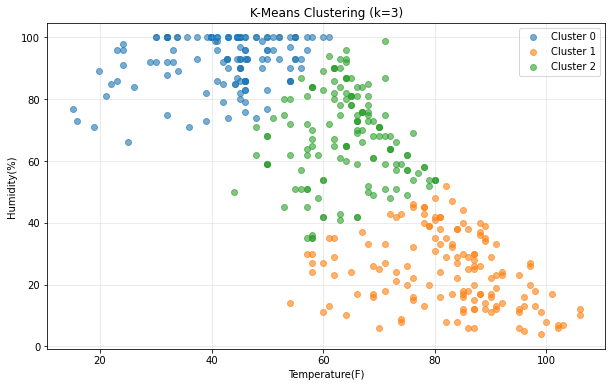

In [12]:
# scatter plot
plt.figure(figsize=(10, 6))
for cluster_id in range(best_k):
    cluster_points = df_vector[df_vector['prediction'] == cluster_id]
    plt.scatter(
        cluster_points["Temperature(F)"], 
        cluster_points["Humidity(%)"],
        label=f"Cluster {cluster_id}",
        alpha=0.6
    )

plt.xlabel("Temperature(F)")
plt.ylabel("Humidity(%)")
plt.title(f"K-Means Clustering (k={best_k})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

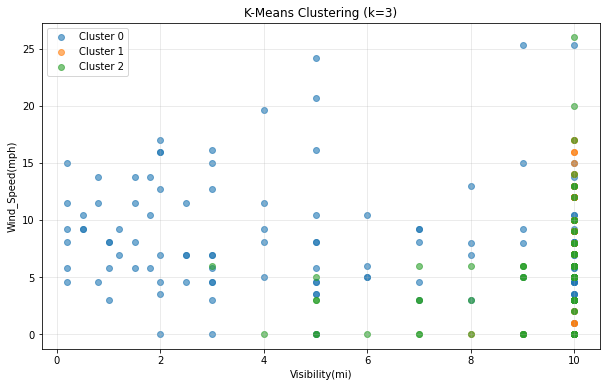

In [13]:
# another visualization with different features
plt.figure(figsize=(10, 6))
for cluster_id in range(best_k):
    cluster_points = df_vector[df_vector['prediction'] == cluster_id]
    plt.scatter(
        cluster_points["Visibility(mi)"], 
        cluster_points["Wind_Speed(mph)"],
        label=f"Cluster {cluster_id}",
        alpha=0.6
    )

plt.xlabel("Visibility(mi)")
plt.ylabel("Wind_Speed(mph)")
plt.title(f"K-Means Clustering (k={best_k})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

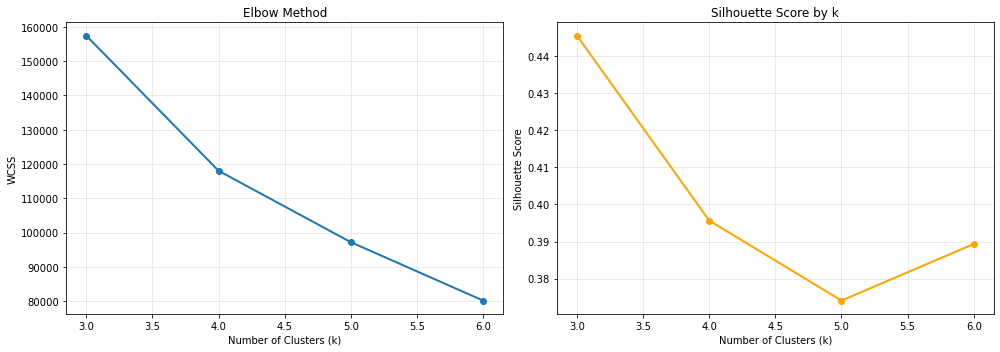

In [14]:
# plot elbow curve
k_vals = [r['k'] for r in results]
wcss_vals = [r['wcss'] for r in results]
silhouette_vals = [r['silhouette'] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_vals, wcss_vals, marker='o', linewidth=2)
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("WCSS")
ax1.set_title("Elbow Method")
ax1.grid(True, alpha=0.3)

ax2.plot(k_vals, silhouette_vals, marker='o', linewidth=2, color='orange')
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score by k")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# compare to dominics original results
print("\n" + "=" * 60)
print("COMPARISON TO BASELINE")
print("=" * 60)

print("\nDominic's Original Clustering (k=4, all 7 features):")
print("  Silhouette Score: 0.4713")
print("  WCSS: 186248.60")
print("  Features: Severity, Temperature, Humidity, Pressure, Visibility, Wind_Speed, Precipitation")

print(f"\nImproved Clustering (k={best_k}, top {len(all_features)} features):")
print(f"  Silhouette Score: {final_silhouette:.4f}")
print(f"  WCSS: {final_wcss:.2f}")
print(f"  Features: {', '.join(all_features[:3])}... ({len(all_features)} total)")

improvement = ((final_silhouette - 0.4713) / 0.4713) * 100
print(f"\nSilhouette improvement: {improvement:+.1f}%")

if final_silhouette > 0.4713:
    print("Result: Improved clustering quality")
elif final_silhouette > 0.45:
    print("Result: Similar clustering quality")
else:
    print("Result: Lower clustering quality (may need more features)")


COMPARISON TO BASELINE

Dominic's Original Clustering (k=4, all 7 features):
  Silhouette Score: 0.4713
  WCSS: 186248.60
  Features: Severity, Temperature, Humidity, Pressure, Visibility, Wind_Speed, Precipitation

Improved Clustering (k=3, top 20 features):
  Silhouette Score: 0.4455
  WCSS: 157426.15
  Features: Temperature(F), Wind_Chill(F), Humidity(%)... (20 total)

Silhouette improvement: -5.5%
Result: Lower clustering quality (may need more features)


In [16]:
# show which features we used
print("\n" + "=" * 60)
print("FEATURES USED")
print("=" * 60)

feature_importance = {
    "Temperature(F)": 0.8496,
    "Wind_Chill(F)": 0.5705,
    "Humidity(%)": 0.5078,
    "Pressure(in)": 0.3684,
    "Traffic_Signal": 0.2706,
    "Visibility(mi)": 0.2491,
    "Wind_Speed(mph)": 0.2225,
    "Traffic_Calming": 0.2145,
    "Precipitation(in)": 0.1942,
    "Stop": 0.1809
}

print("\nTop 10 features (from Siddhant's analysis):")
for i, (feat, imp) in enumerate(feature_importance.items(), 1):
    print(f"{i:2d}. {feat:25s} {imp:.4f}")

print("\nTemporal features (2):")
print("  - rush_hour")
print("  - is_weekend")

print("\nWeather condition flags (4):")
print("  - is_clear")
print("  - is_rainy")
print("  - is_foggy")
print("  - is_snowy")

print("\nRoad type flags (2):")
print("  - is_highway")
print("  - is_local")

print("\nSpatial features (2):")
print("  - state_encoded")
print("  - high_accident_state")

print(f"\nTotal features: {len(all_features)}")


FEATURES USED

Top 10 features (from Siddhant's analysis):
 1. Temperature(F)            0.8496
 2. Wind_Chill(F)             0.5705
 3. Humidity(%)               0.5078
 4. Pressure(in)              0.3684
 5. Traffic_Signal            0.2706
 6. Visibility(mi)            0.2491
 7. Wind_Speed(mph)           0.2225
 8. Traffic_Calming           0.2145
 9. Precipitation(in)         0.1942
10. Stop                      0.1809

Temporal features (2):
  - rush_hour
  - is_weekend

Weather condition flags (4):
  - is_clear
  - is_rainy
  - is_foggy
  - is_snowy

Road type flags (2):
  - is_highway
  - is_local

Spatial features (2):
  - state_encoded
  - high_accident_state

Total features: 20


In [17]:
print("Analysis complete")

Analysis complete
